In [ ]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV,DSP,NLsolve
PythonPlot.svg(true)
include("model.jl")
include("formulas.jl")
FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

# Compare to alpha formula for 2d model

In [9]:
data= CSV.read("./output/sho_data_cells_2d.csv",DataFrame);
data
ω0range = data.ω0 |> unique |> sort;
ηrange = data.η |> unique |> sort;
qrange = data.q |> unique |> sort;

In [10]:
data = data[data.ω0 .< 10,:]
ω0range = data.ω0 |> unique |> sort;
ηrange = data.η |> unique |> sort;
qrange = data.q |> unique |> sort;

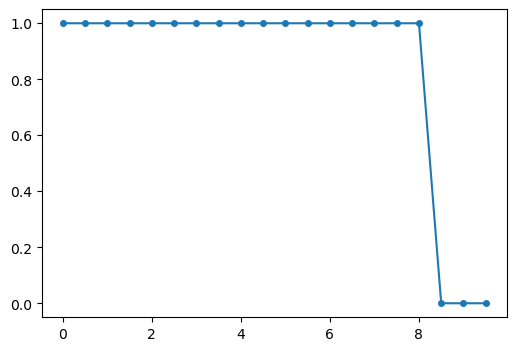

In [11]:
dfu = data[data.q .== qrange[1],:]
P = hcat([[d.isphys[1] for d in groupby(dfuet, :η)] for dfuet in groupby(dfu, :ω0)]...)
fig, ax = subplots(1, 1, figsize=(6, 4))
ax.plot(ω0range, P[6,:], marker="o", markersize=4, linewidth=1.5)
fig

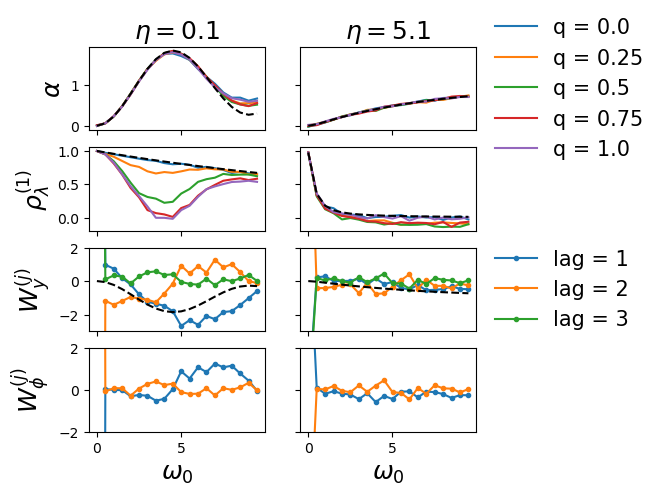

In [27]:
fig,axs = subplots(4,2,figsize=(5,5),sharex=true,sharey="row")
row_labels = ["D", "E", "F", "G"]
ηinds = [1,6]
for i in 1:2
    η = ηrange[ηinds[i]]
    # for row in 1:4
    #     ax = axs[row-1,i-1]
    #     # Add panel label in the upper right corner, not bold, with white background and large font
    #     ax.text(0.3, 0.9, "($(row_labels[row]).$(i))", transform=ax.transAxes, fontsize=15, va="top", ha="right", bbox=Dict("facecolor"=>"white", "edgecolor"=>"none", "pad"=>2.5))
    #     ax.tick_params(labelsize=15)
    # end

    # Row 1: alpha
    ax = axs[0,i-1]
    ax.set_title("\$\\eta = $(η)\$",fontsize=18)
    for j in 1:5:length(qrange)
        q = qrange[j]
        df = data[(data.η .== η) .& (data.q .== q),:]
        αs = [-cov(d.z0, d.ϕ)/var(d.z0) for d in groupby(df, :ω0)]
        ax.plot(ω0range, αs,"-",label="q = $q")
    end
    αs_theory = [alpha_SHO(ω0*η, ω0, 1/log(2), η) for ω0 in ω0range]
    ax.plot(ω0range, αs_theory,"k--")
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(labelbottom=false)  # Remove x tick labels

    # Row 2: rho
    ax = axs[1,i-1]
    for j in 1:5:length(qrange)
        q = qrange[j]
        df = data[(data.η .== η) .& (data.q .== q),:]
        ρs = [cor(d.λ[2:end], d.λ[1:end-1]) for d in groupby(df, :ω0)]
        ax.plot(ω0range, ρs,"-")
    end
    df = data[(data.η .== η) .& (data.q .== qrange[end]),:]
    ρs_theory = [rho_SHO(η, ω0, mean(df[df.ω0 .== ω0range[end],:].λ), 1) for ω0 in ω0range]
    ax.plot(ω0range, ρs_theory,"k--")
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(labelbottom=false)  # Remove x tick labels

    # Row 3: Wz0s[2]
    ax = axs[2,i-1]
    j = 1
    df = data[(data.η .== η) .& (data.q .== qrange[j]),:]
    q = qrange[j]
    Wz0s = []
    for k in 1:length(ω0range)
        d = df[df.ω0 .== ω0range[k], :]
        push!(Wz0s, coarse_grained1D(d,2)[2])
    end
    Wz0s = hcat(Wz0s...)
    [ax.plot(ω0range, Wz0s[j,:], ".-",label="lag = $(j)") for j in 1:size(Wz0s, 1)]
    αs_theory = [alpha_SHO(ω0*η, ω0, 1/log(2), η) for ω0 in ω0range]
    ax.plot(ω0range, -αs_theory,"k--")
    #ax.set_ylim([-5,5])
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(labelbottom=false)  # Remove x tick labels

    # Row 4: Wz0s[1]
    ax = axs[3,i-1]
    j = 1
    df = data[(data.η .== η) .& (data.q .== qrange[j]),:]
    q = qrange[j]
    Wz0s = []
    for k in 1:length(ω0range)
        d = df[df.ω0 .== ω0range[k], :]
        push!(Wz0s, coarse_grained1D(d,2)[1])
    end
    Wz0s = hcat(Wz0s...)
    [ax.plot(ω0range, Wz0s[j,:], ".-",label="lag = $(j)") for j in 1:size(Wz0s, 1)]
    ax.set_xlabel("\$\\omega_0\$",fontsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    # Keep x tick labels for the bottom row (no labelbottom=false here)
end

axs[0,2-1].legend(loc="center left", bbox_to_anchor=(1, 0.5),frameon=false, fontsize=15)
axs[2,2-1].legend(loc="center left", bbox_to_anchor=(1, 0.5),frameon=false, fontsize=15)
axs[0,0].set_ylabel("\$\\alpha\$",fontsize=18)
axs[1,0].set_ylabel("\$\\rho_{\\lambda}^{(1)}\$",fontsize=18)
axs[2,0].set_ylabel("\$W_{y}^{(j)}\$",fontsize=18)
axs[3,0].set_ylabel("\$W_{\\phi}^{(j)}\$",fontsize=18)
axs[2,0].set_ylim([-3,2])
axs[3,0].set_ylim([-2,2])

#tight_layout()
savefig(joinpath(FIG_PATH, "fig3_grid.pdf"), bbox_inches="tight",format="pdf")
fig

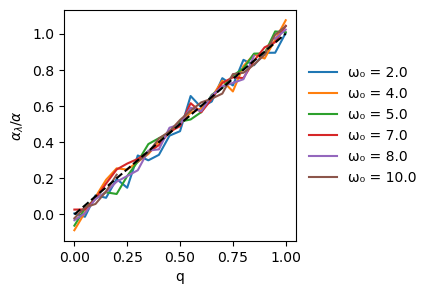

In [13]:
fig,axs = subplots(figsize=(3, 3),sharex=true)

ax = axs #[0]
η =  ηrange[end]
j = 0
for ω0 in ω0range[5:3:end]
    df = data[(data.η .== η) .& (data.ω0 .== ω0), :]
    α = [-cov(d.ϕ, d.z0) / var(d.z0) for d in groupby(df, :q)]
    αλ = [-cov(d.ϕ ./ d.τ, d.z0) / var(d.z0) * mean(d.τ) for d in groupby(df, :q)]
    ax.plot(qrange,αλ ./α,"C$(j)-",label = "ω₀ = $(round(ω0; sigdigits=1))")
    j = j+ 1
end
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5),frameon=false)
#ax.set_ylim([0,1.2])
#ax.legend()
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
ax.plot(qrange,qrange,"k--")
ax.set_ylabel("\$\\alpha_{\\lambda}/\\alpha \$")

# ax = axs[1]
# η =  ηrange[end]
# j = 0
# for ω0 in ω0range[10:10:end]
#     df = data[(data.η .== η) .& (data.ω0 .== ω0), :]
#     ρ = [-cov(d.λ[2:end], d.λ[1:end-1]) / var(d.λ) for d in groupby(df, :q)]
#     ax.plot(qrange,ρ,"C$(j)-",label="ω0 = $(ω0)")
#     j = j+ 1
# end

ax.set_xlabel("q")
# ax.set_ylabel("\$\\Sigma_{\\lambda,\\lambda}^{(1)} \$")
savefig(joinpath(FIG_PATH, "fig4_alphalam.pdf"), bbox_inches="tight", pad_inches=0.1, format="pdf")
fig

In [18]:
ηrange

10-element Vector{Float64}:
 0.1
 1.1
 2.1
 3.1
 4.1
 5.1
 6.1
 7.1
 8.1
 9.1

In [7]:
# Eigenvalues

In [3]:

# Parameters
d = 5
ρx = randn(d)
fy = randn(d)
a = rand(d) .+ 1.0  # ensure a_i + μ ≠ 0 near μ=0

# Define function f(μ)
function f(μ::ComplexF64)
    sum = -μ
    for i in 1:d
        sum += ρx[i] * fy[i] / (a[i] + μ)
    end
    return sum
end

# Wrapper to use in NLsolve
function fvec!(F, x)
    μ = complex(x[1], x[2])
    y = f(μ)
    F[1] = real(y)
    F[2] = imag(y)
end


fvec! (generic function with 1 method)

UndefVarError: UndefVarError: `nlsolve` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# MISC

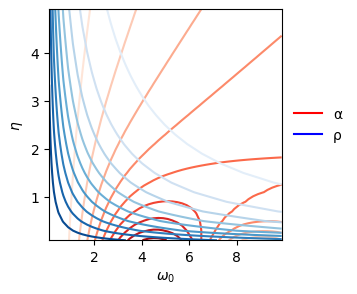

In [57]:

ηrange_ = collect(0.1:0.2:5.0)
ω0range_ = collect(0.1:0.2:10.0)

# Preallocate
alpha_vals = zeros(length(ω0range_), length(ηrange_))
rho_vals = zeros(length(ω0range_), length(ηrange_))


# Populate the matrix
for (i, ω0) in enumerate(ω0range_)
    for (j, η) in enumerate(ηrange_)
        alpha_vals[i, j] = alpha_SHO(η * ω0, ω0, 1 / log(2), η)
        rho_vals[i, j] = rho_SHO(η, ω0, 1 / log(2), 1)
    end
end

# Transpose for correct orientation in PyPlot
alpha_vals = alpha_vals'
rho_vals = rho_vals'



# Plot
fig, ax = subplots(figsize=(3, 3))


cs2 = ax.contour(ω0range_,ηrange_,alpha_vals,levels=10,cmap="Reds")
cs1 = ax.contour(ω0range_,ηrange_,rho_vals,levels=10,cmap="Blues")
ax.plot([1],[1],"r-",label="α")
ax.plot([1],[1],"b-",label="ρ")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5),frameon=false)
ax.set_xlabel("\$\\omega_0\$")
ax.set_ylabel("\$\\eta\$")
savefig(joinpath(FIG_PATH, "fig3_contour.pdf"), bbox_inches="tight", pad_inches=0, format="pdf")
fig



In [ ]:
#